<a href="https://colab.research.google.com/github/DanielL35/turtle-face-detection/blob/main/yoloV5_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The sea turtle face detection challenge 🐢

This is an approach to solve the sea turtle face detection challenge by zindi:

https://zindi.africa/competitions/local-ocean-conservation-sea-turtle-face-detection

The aim is to develop a "tool that can crop a given image to show only the important facial region."

I've used YOLOv5 segmentation to draw bounding boxe around the turtle heads:

https://blog.roboflow.com/train-yolov5-instance-segmentation-custom-dataset/

# Setting Up The Environment for YOLOv5 Segmentation

First, we need to clone the Ultralytics YOLOv5 repo and install all its dependancies.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks




YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.6/107.7 GB disk)


# Downloading the annotated images from roboflow

I am using roboflow to draw polygons around the turtle heads and create the data set.
Yet roboflow allows you to do this for free, it is a commercial service and is intended to be replaced with an open-source solution in the future. The data set consists of 59 annotated images which are being augmented with the following methods: 
+ Flip: Horizontal
+ Rotation: Between -15° and +15°
+ Shear: ±15° Horizontal, ±15° Vertical
+ Blur: Up to 10px . Eventually 

However, the free plan only allows you to output a limited number of augmented images per training example, which results in 145 images.

In [ ]:
!pip install roboflow

# this code snipped downloads all the images from your private robofolow project
from roboflow import Roboflow
rf = Roboflow(api_key="2J76WjwYrT0tLCRiTgrh")
project = rf.workspace("daniel-busch-2uwdr").project("zindi-turtle-face-detection-challenge")
dataset = project.version(2).download("yolov5")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=651527fdefa460eb2db5a080eebe9cea8fc4690fbe44f549a3d0e163fe125ccb
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pypars

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to zindi-turtle-face-detection-challenge-2 in yolov5pytorch:: 100%|██████████| 302/302 [00:00<00:00, 1040.41it/s]


# Dowloading weights from yolov5

download some pre-trained weights so we aren't starting from scratch

In [ ]:
%cd ../yolov5

from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-seg' for x in p5]  # segmentation models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

/content/yolov5


  0%|          | 0.00/4.11M [00:00<?, ?B/s]

  0%|          | 0.00/14.9M [00:00<?, ?B/s]

  0%|          | 0.00/42.4M [00:00<?, ?B/s]

  0%|          | 0.00/91.9M [00:00<?, ?B/s]

  0%|          | 0.00/170M [00:00<?, ?B/s]

# Train the model


segment/train: weights=yolov5s-seg.pt, cfg=, data=/content/yolov5/zindi-turtle-face-detection-challenge-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, mask_ratio=4, no_overlap=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4

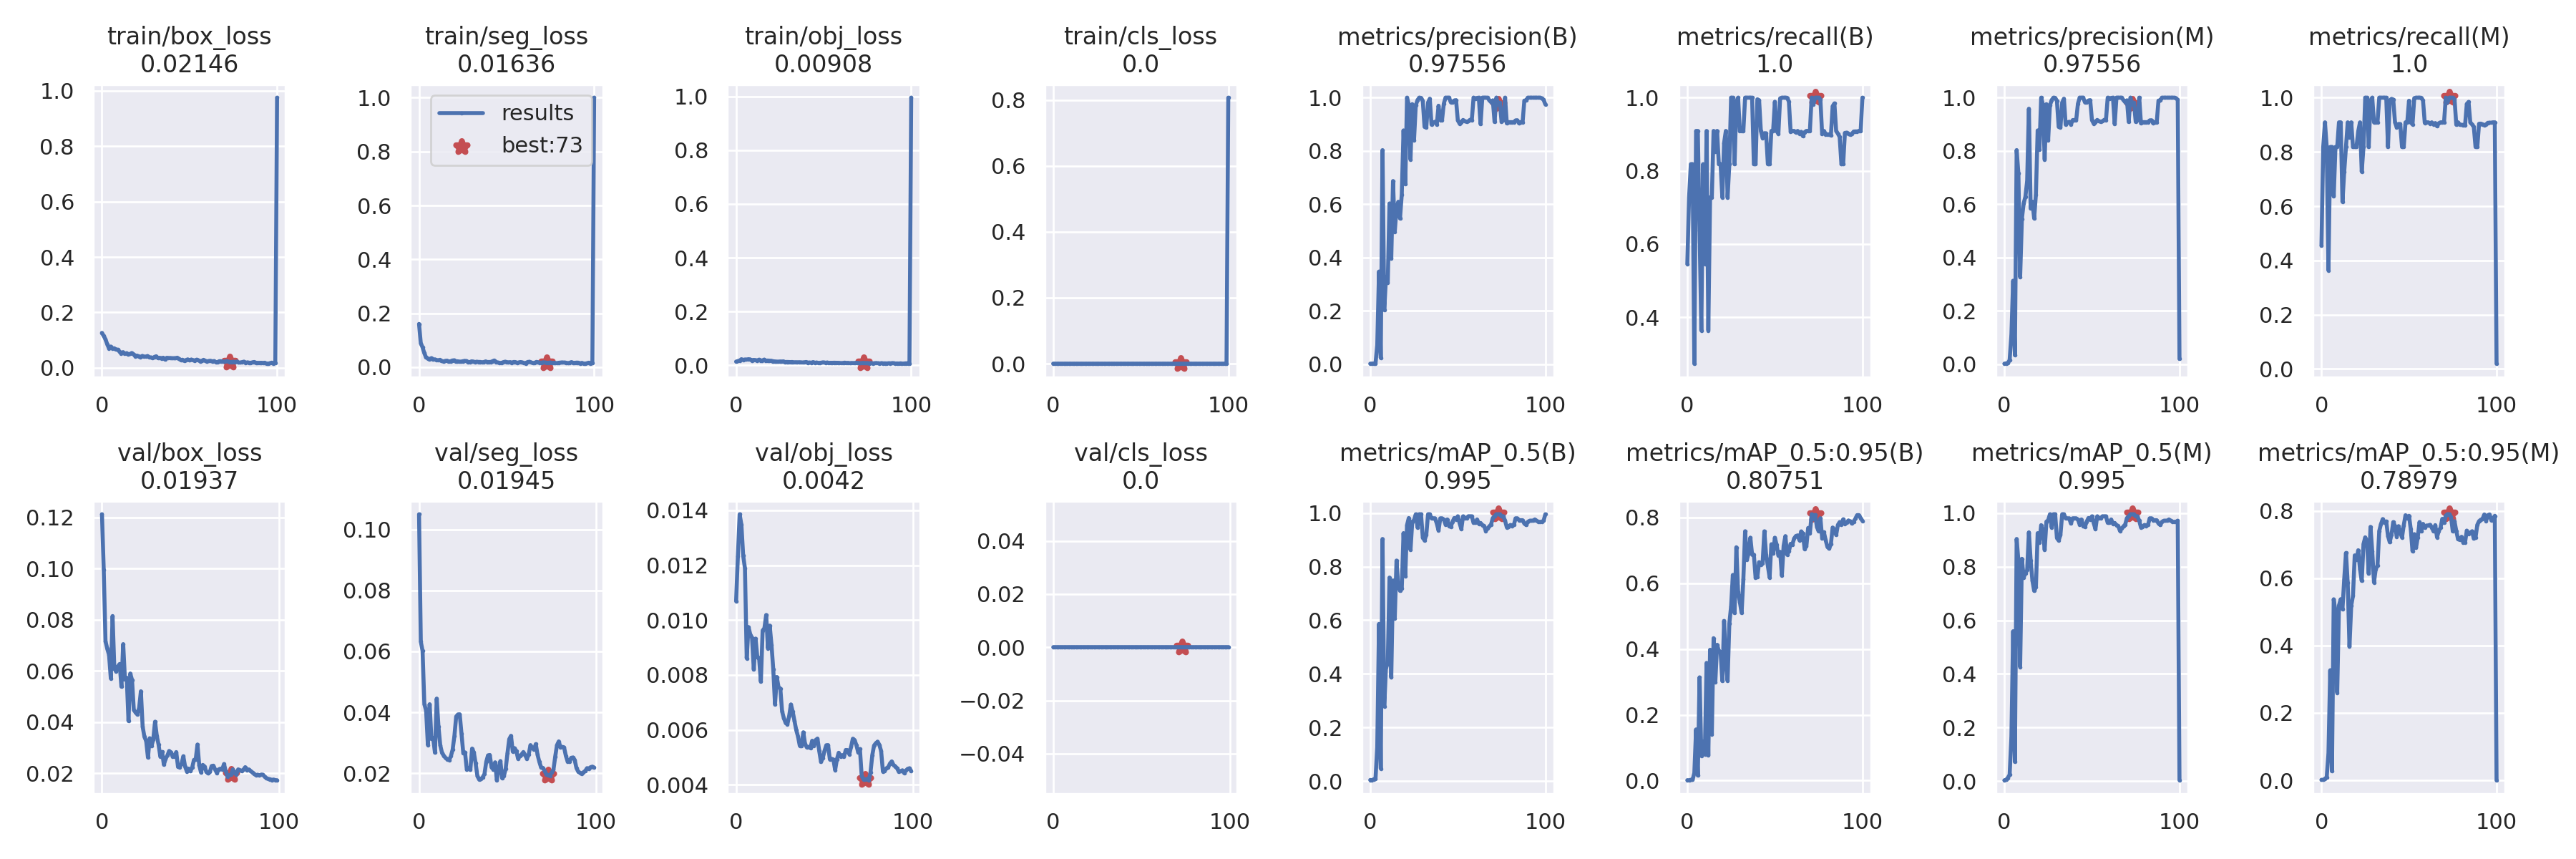

In [ ]:
!python segment/train.py --img 320 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5s-seg.pt
display.Image(filename=f'runs/train-seg/exp/results.png', width=1200)

In [ ]:
# reports the results of the instance segmentation training

!python segment/val.py --weights runs/train-seg/exp/weights/best.pt --data {dataset.location}/data.yaml --img 320

segment/val: data=/content/yolov5/zindi-turtle-face-detection-challenge-2/data.yaml, weights=['runs/train-seg/exp/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
val: Scanning /content/yolov5/zindi-turtle-face-detection-challenge-2/valid/labels.cache... 11 images, 0 backgrounds, 0 corrupt: 100% 11/11 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 1/1 [00:02<00:00,  2.03s/it]
                   all         11         11      0.975          1      0.995      0.808      0.975

# Predict bounding boxes from testing set

At this point the model is trained and ready to predict the bounding boxes arounf the turtle heads.

In [ ]:
# mount your google drive to access the testing set and save the final results in the end
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# read in the list of filenames of the test set
# the file SampleSubmission.csv lists all the image ids that should
# be submitted to zindi

import pandas as pd
submission = pd.read_csv('/content/drive/MyDrive/zindi/SampleSubmission.csv')

In [ ]:
# let's look at the first entries of the list
submission['Image_ID'][:10]

0    4863D911
1    6DD3ADD5
2    E8DC4D6A
3    E02ABB6C
4    875C19F4
5    5BEAAECC
6    51ACD6F6
7    A79140B3
8    678A0DB3
9    9362F0D5
Name: Image_ID, dtype: object

In [ ]:
# save all images in the google colab drive
!cp '/content/drive/MyDrive/zindi/IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder = 'IMAGES_512'


In [ ]:
# let's look at the folder structure of the project
# this is the YOLOv5 package, with the train set in zindi-turtle-face-detection-challenge-2
# and the testing set in IMAGES_512
!ls

benchmarks.py	 IMAGES_512.zip    setup.cfg
CITATION.cff	 LICENSE	   train.py
classify	 models		   tutorial.ipynb
CONTRIBUTING.md  __pycache__	   utils
data		 README.md	   val.py
detect.py	 README.zh-CN.md   weights
export.py	 requirements.txt  yolov5s-seg.pt
hubconf.py	 runs		   zindi-turtle-face-detection-challenge-2
IMAGES_512	 segment


It is recommended to look at the predict.py function of YOLOv5 to understand the use of arguments.

https://github.com/ultralytics/yolov5/blob/064365d8683fd002e9ad789c1e91fa3d021b44f0/segment/predict.py#L66

The arguments I used here:
+ --source: specifies the source of the image you want to predict
+ --save-txt: this textfile holds the coordinates of your polygon which can then be translated to a bounding box
+ --nonosave: we don't need to output the image of the turtle with the visual result of the segmentation 
+ --exist-ok: this allows you to save all text files in one folde which I find more convenient
+ --max-det: the maximum detections per image are set to one. It is impossible that there will be two turtle heads in the image, so every second detected class
will be wrong

In [ ]:
# loop through all testing images and save the results only as a textfile 
# in /content/yolov5/runs/predict-seg/exp/labels
image_names_test = submission['Image_ID']
for image_name in image_names_test:
    !python segment/predict.py --img 320 --weights runs/train-seg/exp/weights/best.pt --source '{image_folder}/{image_name}.JPG' --save-txt --nosave --exist-ok --max-det 1


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Model summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
image 1/1 /content/yolov5/IMAGES_512/BACF93EE.JPG: 256x320 1 turtle-head, 112.7ms
Speed: 0.6ms pre-process, 112.7ms inference, 0.9ms NMS per image at shape (1, 3, 320, 320)
Results saved to runs/predict-seg/exp
137 labels saved to runs/predict-seg/exp/labels
segment/predict: weights=['runs/train-seg/exp/weights/best.pt'], source=IMAGES_512/404AFEBF.JPG, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=True, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model sum

In [ ]:
# copy the results to google drive
# so we don't have to repeat the training process to look at the results
!cp -r '/content/yolov5/runs/predict-seg/exp/labels' '/content/drive/MyDrive/zindi/'

# convert text files to bounding box coordinates

All the results are saved as polygons in text files. Now it is time to translate them into bounding box coordinates and bring them in the right format for submission. Zindi requires a csv file with the rows:
+ Image_ID
+ x (the x coordinate of the lower left point of the bounding box)
+ y (the y coordinate of the lower left point of the bounding box)
+ w (the width of the boundin box)
+ h (the height of the bounding box)

This tutorial gives an explanation how these text files are composed:

https://medium.com/mlearning-ai/yolov5-for-segmentation-fab39c3487f6

In [ ]:
# metrics for submission
id_index, x, y, w, h = [], [], [], [], []

# create a subsample for initial testing
subsample_image_names = submission['Image_ID']


# loop through all predicted polygons
for image_name in subsample_image_names:
  
  # generate the path of the text file
  textfile = f'/content/yolov5/runs/predict-seg/exp/labels/{image_name}.txt'

  # try to access the file
  try:
      # open the text file
      with open(textfile, 'r') as fobj:
        # split the words (coordinates)
        mylis = fobj.read().split()

      # make sure they are float format
      mylis = [float(i) for i in mylis]
      # the first digit will be number of the class (in our case 0)
      coords = mylis[1:]

      # all the even numbers are x coords
      # all the odd numbers are y coords
      xmin = min(coords[::2])
      xmax = max(coords[::2])
      ymin = min(coords[1::2])
      ymax = max(coords[1::2])

      # append the coordinates to the lists
      x.append(xmin)
      y.append(ymin)
      w.append(xmax - xmin)
      h.append(ymax - ymin)

  # if the previous code throws an error, the text file is not found
  # hence there was no class detected in the image
  except:
  # in this case create an arbitrary bounding box and print a message
      print(f'No class detected for {image_name}')
      x.append(0.25)
      y.append(0.25)
      w.append(0.5)
      h.append(0.5)
  # append the image_id to the list 
  id_index.append(image_name)

# save everything as a data frame
result = pd.DataFrame({'Image_ID':id_index,
                       'x':x,
                       'y':y,
                       'w':w,
                       'h':h                      
                       })

# save it to google drive
result.to_csv('/content/drive/MyDrive/zindi/result_yolo5.csv', index=False)

In [ ]:
# check the length of the result data frame to make sure we got everything
len(result)

695

In [ ]:
# check if the data frame looks as it should
result

,Image_ID,x,y,w,h
0,4863D911,0.153125,0.300000,0.628125,0.529167
1,6DD3ADD5,0.325000,0.316667,0.381250,0.454166
2,E8DC4D6A,0.353125,0.512500,0.437500,0.445833
3,E02ABB6C,0.337500,0.516667,0.431250,0.445833
4,875C19F4,0.375000,0.466667,0.396875,0.395833
5,5BEAAECC,0.475000,0.466667,0.156250,0.195833
6,51ACD6F6,0.375000,0.400000,0.418750,0.337500
7,A79140B3,0.325000,0.516667,0.318750,0.312500
8,678A0DB3,0.375000,0.433333,0.456250,0.416667


# Plot the results
Finally the resulting bounding boxes can be plotted on the turtle images from the testing set.
The results are already processed and saved, so this is not really necessary but gives you a better idea about your predictions. There should be another plot where the predicted bounding boxes are compared to the ones uploaded in the zindi challenges. This way the model can be assessed and improved.

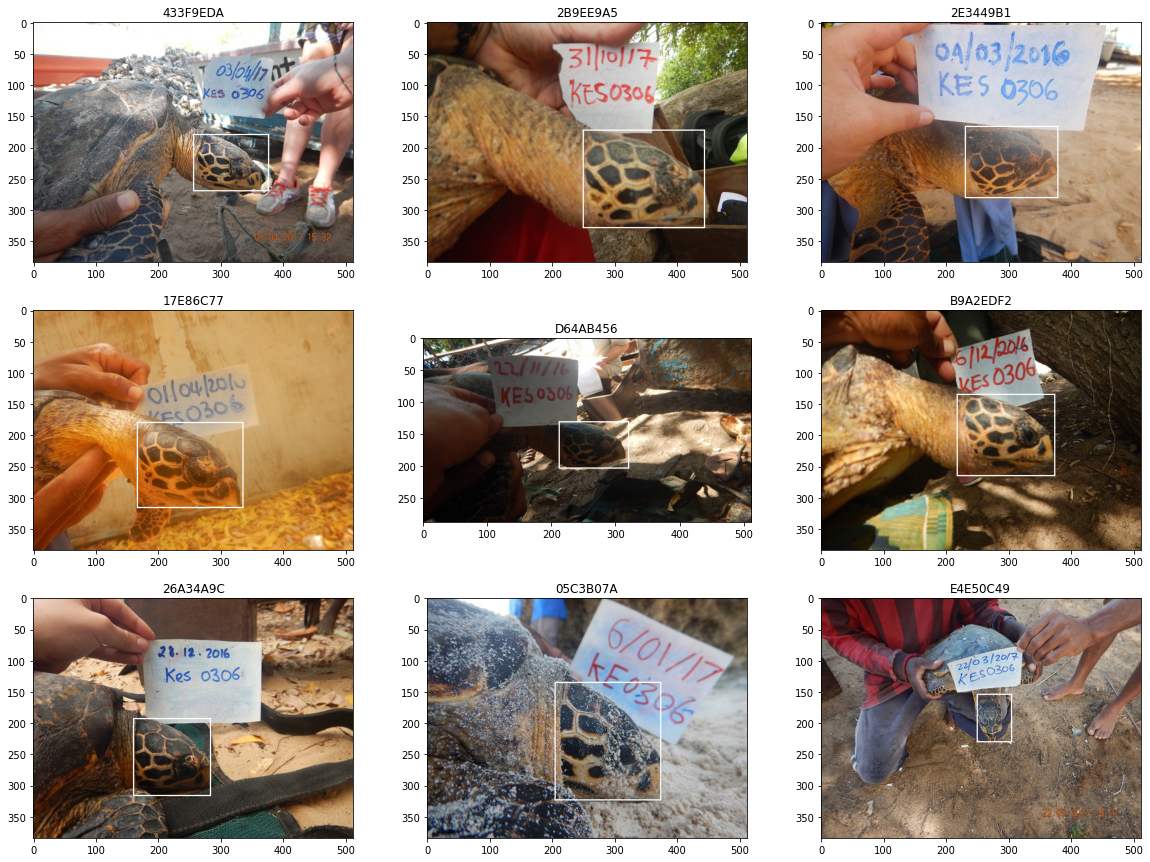

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# specify the size of the images - 512 pixels and RGB
input_shape = (512, 512, 3)
img_size = input_shape[:2]

# create a plot
fig = plt.figure(figsize=(20,15))

# plot 9 images from the submission set and their predicted bounding boxes
# select 9 images from the submission set
# this is done manually at the moment but should be random selection 
# in the future
result_plot = result[150:159].reset_index()

# loop through the results data frame
for i, row in result_plot.iterrows():
    # create 9 subplots
    ax = plt.subplot(3,3,i+1)
    # open an image
    with Image.open(f'{image_folder}/{row["Image_ID"]}.JPG') as img:
      imw, imh = img.size # Box coords are relative to image size
      # draw the image
      draw = ImageDraw.Draw(img)
      # draw the bounding box
      draw.rectangle([int(row['x']*imw),
                      int(row['y']*imh),
                      int((row['x']+row['w'])*imw),
                      int((row['y']+row['h'])*imh)],
                     width=2) 
    # plot image
    ax.imshow(img)
    # add title
    ax.set_title(row['Image_ID'])
    
# show plot    
plt.show()